In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [3]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    ONE_AND_HALF_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [51]:
from replay_trajectory_classification import SortedSpikesClassifier
from src.sorted_spikes_simulation import make_simulated_run_data

(
    time,
    linear_distance,
    sampling_frequency,
    spikes,
    place_fields,
) = make_simulated_run_data()

classifier = SortedSpikesClassifier(
    movement_var=6.0,
    replay_speed=1,
    spike_model_penalty=0.5,
    place_bin_size=3.0,
    discrete_transition_diag=0.98,
)
classifier.fit(linear_distance, spikes)

SortedSpikesClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                     'identity'],
                                                    ['uniform', 'uniform',
                                                     'uniform'],
                                                    ['random_walk', 'uniform',
                                                     'identity']],
                       discrete_transition_diag=0.98,
                       discrete_transition_type='strong_diagonal',
                       infer_track_interior=True,
                       initial_conditions_type='uniform_on_track',
                       knot_spacing=10, movement_var=6.0, place_bin_size=3.0,
                       position_range=None, replay_speed=1,
                       spike_model_penalty=0.5)

In [59]:
from src.sorted_spikes_simulation import (
    make_fragmented_hover_continuous_replay,
    SAMPLING_FREQUENCY,
)
from src.parameters import STATE_ORDER, STATE_COLORS, TRANSITION_TO_CATEGORY

replay_time, test_spikes = make_fragmented_hover_continuous_replay()
replay_time *= SAMPLING_FREQUENCY
results = classifier.predict(test_spikes, time=replay_time).assign_coords(
    state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
)
results

<xarray.Dataset>
Dimensions:            (position: 60, state: 3, time: 350)
Coordinates:
  * time               (time) float64 0.0 1.0 2.0 3.0 ... 347.0 348.0 349.0
  * position           (position) float64 1.5 4.5 7.5 10.5 ... 172.5 175.5 178.5
  * state              (state) object 'Continuous' 'Fragmented' 'Hover'
Data variables:
    likelihood         (time, state, position) float64 0.9996 0.999 ... 0.001285
    causal_posterior   (time, state, position) float64 0.005567 ... 5.281e-06
    acausal_posterior  (time, state, position) float64 0.002019 ... 5.281e-06

In [222]:
from src.analysis import get_is_classified, get_probability
from src.parameters import PROBABILITY_THRESHOLD


def plot_spikes(test_spikes, replay_time, ax=None, cmap=plt.get_cmap("tab20")):
    if ax is None:
        ax = plt.gca()
    spike_ind, neuron_ind = np.nonzero(test_spikes)

    c = ["black" for ind in neuron_ind]
    ax.eventplot(
        replay_time[spike_ind][:, np.newaxis],
        lineoffsets=neuron_ind + 1,
        colors=c,
        linewidth=2,
        clip_on=False,
    )
    ax.set_yticks((1, test_spikes.shape[1]))
    ax.set_ylabel("Cells")
    ax.set_ylim((1, test_spikes.shape[1]))
    ax.set_xlabel("Time [ms]")
    ax.set_xlim((replay_time.min(), replay_time.max() + 1))
    ax.set_xticks((replay_time.min(), replay_time.max() + 1))
    ax.set_title("Spike Trains", fontsize=12)
    sns.despine(offset=5)


def plot_probabilities(results, ax=None):
    if ax is None:
        ax = plt.gca()
    probabilities = results.acausal_posterior.sum("position").values

    for probability, state in zip(probabilities.T, results.state.values):
        ax.plot(
            results.time,
            probability,
            linewidth=2,
            label=state,
            color=STATE_COLORS[state],
            clip_on=False,
        )
    xlim = results.time.min(), results.time.max() + 1
    ax.set_xticks(xlim)
    ax.set_xlim(xlim)
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Probability")
    ax.set_yticks([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title("Probability of Movement State", fontsize=12)
    sns.despine(offset=5, ax=ax)


def plot_posterior(
    classifier,
    results,
    linear_distance,
    ax=None,
    cbar_orientation="vertical",
    cbar_aspect=50,
):
    if ax is None:
        ax = plt.gca()

    try:
        posterior = results.acausal_posterior.sum("state").values.T
    except ValueError:
        posterior = results.acausal_posterior.values.T

    t, p = np.meshgrid(np.arange(results.time.size + 1), classifier.place_bin_edges_)

    h = ax.pcolormesh(
        t,
        p,
        posterior,
        vmin=0.0,
        vmax=np.percentile(posterior, 97.5),
        rasterized=True,
        cmap="bone_r",
    )
    cbar = plt.colorbar(
        h,
        label="Probability",
        aspect=cbar_aspect,
        ticks=[0, np.percentile(posterior, 97.5)],
        ax=ax,
        orientation=cbar_orientation,
        extend="max",
    )
    cbar.ax.set_yticklabels(["0", "Max"])  # vertically oriented colorbar
    cbar.outline.set_visible(False)

    ax.set_title("Probability of Latent Position", fontsize=12)

    xlim = results.time.min(), results.time.max() + 1
    ax.set_xticks(xlim)
    ax.set_xlim(xlim)
    ax.set_xlabel("Time [ms]")

    ylim = linear_distance.min(), linear_distance.max()
    ax.set_yticks(ylim)
    ax.set_ylim(ylim)
    ax.set_ylabel("Position [cm]")
    sns.despine()

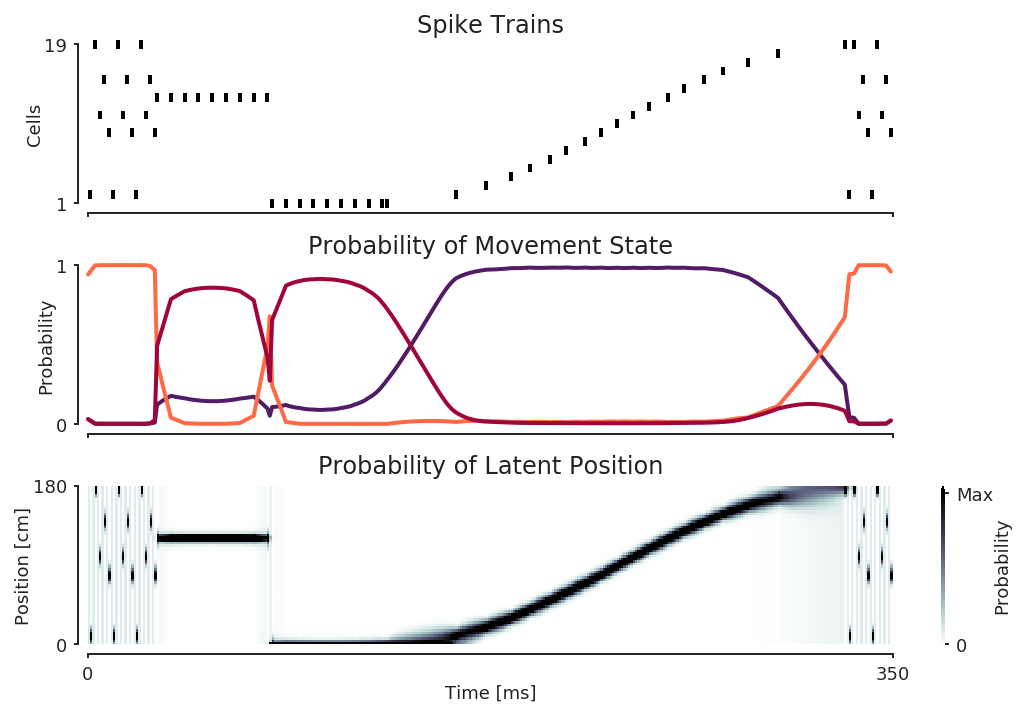

In [216]:
fig, axes = plt.subplots(
    3, 1, figsize=(TWO_COLUMN, PAGE_HEIGHT / 2), constrained_layout=True
)

plot_spikes(test_spikes, replay_time, ax=axes[0])
axes[0].set_xlabel("")
axes[0].set_xticklabels([])
plot_probabilities(results, ax=axes[1])
axes[1].set_xlabel("")
axes[1].set_xticklabels([])
plot_posterior(classifier, results, linear_distance, ax=axes[2])
sns.despine(offset=5)

save_figure(os.path.join("talk", "full_simulated_example"))

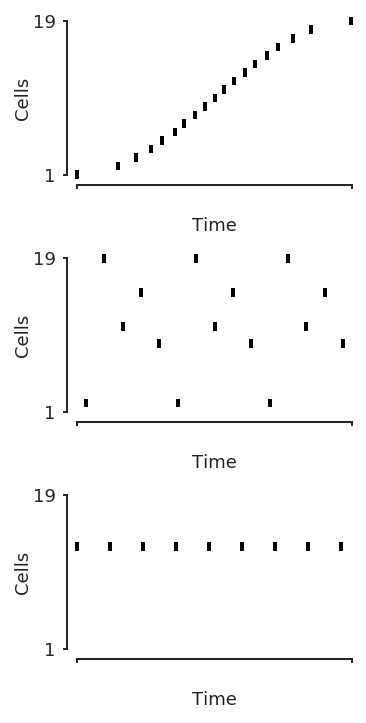

In [211]:
from src.sorted_spikes_simulation import (
    make_fragmented_replay,
    make_hover_replay,
    make_continuous_replay,
)

fig, axes = plt.subplots(
    3,
    1,
    figsize=(PAGE_HEIGHT / 2 / 2, 0.7 * TWO_COLUMN),
    constrained_layout=True,
    sharex=False,
    sharey=True,
)

# Continuous
continuous_spikes = make_continuous_replay()[1]
continuous_time = np.arange(continuous_spikes.shape[0])
plot_spikes(continuous_spikes, continuous_time, ax=axes[0])
axes[0].set_title("")
axes[0].set_xlabel("")
axes[0].set_xticklabels([])

# Fragmented
fragmented_spikes = np.concatenate(
    [
        make_fragmented_replay()[1],
        make_fragmented_replay()[1],
        make_fragmented_replay()[1],
    ]
)
fragmented_time = np.arange(fragmented_spikes.shape[0])

plot_spikes(fragmented_spikes, fragmented_time, ax=axes[1])
axes[1].set_title("")
axes[1].set_xlabel("")
axes[1].set_xticklabels([])


# Stationary
stationary_spikes = np.concatenate([make_hover_replay(hover_neuron_ind=12)[1],])

stationary_time = np.arange(stationary_spikes.shape[0])

plot_spikes(stationary_spikes, stationary_time, ax=axes[2])
# axes[2].set_title("Stationary", pad=10)
axes[2].set_xticklabels([])
axes[2].set_xlabel("")
axes[2].set_title("")

axes[0].set_xlabel("\nTime")
axes[1].set_xlabel("\nTime")
axes[2].set_xlabel("\nTime")
sns.despine(offset=5)
save_figure(os.path.join("talk", "simulated_spikes"))

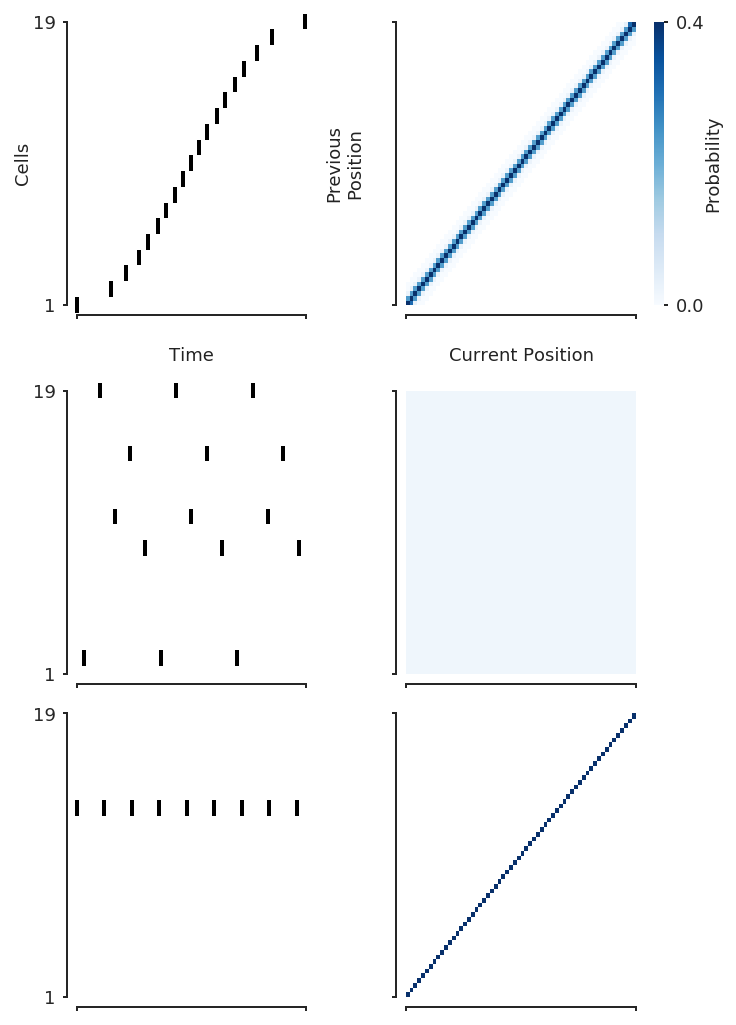

In [233]:
from src.parameters import TRANSITION_TO_CATEGORY

vmax = 0.4
fig, axes = plt.subplots(
    3, 2, figsize=(5, 7), sharex=False, sharey=False, constrained_layout=True,
)

# Continuous
continuous_spikes = make_continuous_replay()[1]
continuous_time = np.arange(continuous_spikes.shape[0])
plot_spikes(continuous_spikes, continuous_time, ax=axes[0, 0])
axes[0, 0].set_title("")
axes[0, 0].set_xlabel("\nTime")
axes[0, 0].set_xticklabels([])

# Fragmented
fragmented_spikes = np.concatenate(
    [
        make_fragmented_replay()[1],
        make_fragmented_replay()[1],
        make_fragmented_replay()[1],
    ]
)
fragmented_time = np.arange(fragmented_spikes.shape[0])

plot_spikes(fragmented_spikes, fragmented_time, ax=axes[1, 0])
axes[1, 0].set_title("")
axes[1, 0].set_ylabel("")
axes[1, 0].set_xlabel("")
axes[1, 0].set_xticklabels([])

# Stationary
stationary_spikes = np.concatenate([make_hover_replay(hover_neuron_ind=12)[1],])

stationary_time = np.arange(stationary_spikes.shape[0])

plot_spikes(stationary_spikes, stationary_time, ax=axes[2, 0])
axes[2, 0].set_title("")
axes[2, 0].set_ylabel("")
axes[2, 0].set_xticklabels([])
axes[2, 0].set_xlabel("")

# State Transition
x, y = np.meshgrid(classifier.place_bin_edges_, classifier.place_bin_edges_)
state_names = [
    TRANSITION_TO_CATEGORY[transition]
    for transition in np.diag(classifier.continuous_transition_types)
]
STATE_ORDER = ["Continuous", "Fragmented", "Hover"]

for (ax, name) in zip(axes[:, 1], STATE_ORDER):
    k = state_names.index(name)
    state_transition = classifier.continuous_state_transition_[k, k]
    state_transition[np.isclose(state_transition, 0.0)] = np.nan
    cmap = plt.cm.Blues
    cmap.set_bad(color="white", alpha=1.0)
    h = ax.pcolormesh(
        x, y, state_transition, cmap=cmap, vmin=0.0, vmax=vmax, rasterized=True,
    )
    ax.set_xticks(
        [classifier.place_bin_edges_.min(), classifier.place_bin_edges_.max()]
    )
    ax.set_xticklabels([])
    ax.set_yticks(
        [classifier.place_bin_edges_.min(), classifier.place_bin_edges_.max()]
    )
    ax.set_yticklabels([])

cbar = fig.colorbar(
    h, label="Probability", ticks=[0, vmax], orientation="vertical", ax=axes[0, 1],
)
cbar.ax.set_xticks([0, vmax])  # vertically oriented colorbar
cbar.ax.set_xticklabels(["0", "Max"])  # vertically oriented colorbar
cbar.outline.set_visible(False)
dist_lim = (classifier.place_bin_edges_.min(), classifier.place_bin_edges_.max())
axes[1, -1].set_xticks(dist_lim)
axes[1, -1].set_yticks(dist_lim)
axes[0, 1].set_xlabel("\nCurrent Position")
axes[0, 1].set_ylabel("Previous\nPosition\n")

sns.despine(offset=5)
ax.set_xticklabels([])
ax.set_yticklabels([])
save_figure(os.path.join("talk", "spikes_continuous_state_transition"))

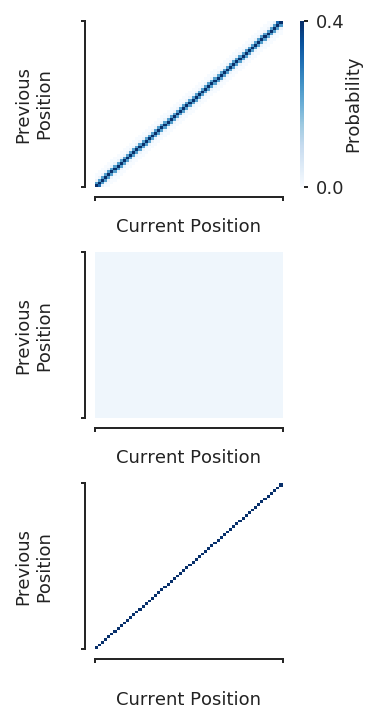

In [246]:
from src.parameters import TRANSITION_TO_CATEGORY

vmax = 0.4
fig, axes = plt.subplots(
    3,
    1,
    figsize=(2.5, 0.7 * TWO_COLUMN),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

# State Transition
x, y = np.meshgrid(classifier.place_bin_edges_, classifier.place_bin_edges_)
state_names = [
    TRANSITION_TO_CATEGORY[transition]
    for transition in np.diag(classifier.continuous_transition_types)
]
STATE_ORDER = ["Continuous", "Fragmented", "Hover"]

for (ax, name) in zip(axes, STATE_ORDER):
    k = state_names.index(name)
    state_transition = classifier.continuous_state_transition_[k, k]
    state_transition[np.isclose(state_transition, 0.0)] = np.nan
    cmap = plt.cm.Blues
    cmap.set_bad(color="white", alpha=1.0)
    h = ax.pcolormesh(
        x, y, state_transition, cmap=cmap, vmin=0.0, vmax=vmax, rasterized=True,
    )
    ax.set_xticks(
        [classifier.place_bin_edges_.min(), classifier.place_bin_edges_.max()]
    )
    ax.set_xticklabels([])
    ax.set_yticks(
        [classifier.place_bin_edges_.min(), classifier.place_bin_edges_.max()]
    )
    ax.set_yticklabels([])
    ax.set_xlabel("\nCurrent Position")
    ax.set_ylabel("Previous\nPosition\n")

cbar = fig.colorbar(
    h, label="Probability", ticks=[0, vmax], orientation="vertical", ax=axes[0],
)
cbar.ax.set_xticks([0, vmax])  # vertically oriented colorbar
cbar.ax.set_xticklabels(["0", "Max"])  # vertically oriented colorbar
cbar.outline.set_visible(False)


sns.despine(offset=5)
ax.set_xticklabels([])
ax.set_yticklabels([])
save_figure(os.path.join("talk", "continuous_state_transition"))

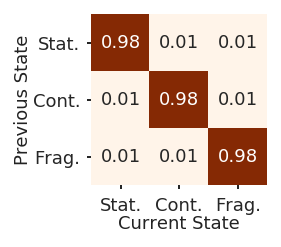

In [174]:
state_names = ["Stat.", "Cont.", "Frag."]
fig, ax = plt.subplots(figsize=(ONE_COLUMN * 0.45, ONE_COLUMN * 0.45))
m = sns.heatmap(
    pd.DataFrame(
        classifier.discrete_state_transition_, index=state_names, columns=state_names
    ),
    annot=True,
    cmap="Oranges",
    ax=ax,
    cbar=False,
    annot_kws=dict(fontsize=9),
    cbar_kws=dict(label="Probability", ticks=[0, 1], orientation="horizontal"),
    vmin=0.0,
    vmax=1.0,
)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.ylabel("Previous State")
plt.xlabel("Current State")
save_figure(os.path.join("talk", "discrete_state_transition"))

In [212]:
from replay_trajectory_classification import SortedSpikesDecoder
from src.sorted_spikes_simulation import make_simulated_run_data

decoder = SortedSpikesDecoder(
    movement_var=6.0, replay_speed=1, spike_model_penalty=0.5, place_bin_size=3.0,
)
decoder.fit(linear_distance, spikes)

SortedSpikesDecoder(infer_track_interior=True,
                    initial_conditions_type='uniform_on_track', knot_spacing=10,
                    movement_var=6.0, place_bin_size=3.0, position_range=None,
                    replay_speed=1, spike_model_penalty=0.5,
                    transition_type='random_walk')

In [214]:
from src.sorted_spikes_simulation import (
    make_continuous_replay,
    SAMPLING_FREQUENCY,
)
from src.parameters import STATE_ORDER, STATE_COLORS, TRANSITION_TO_CATEGORY

replay_time2, test_spikes2 = make_continuous_replay()
replay_time2 *= SAMPLING_FREQUENCY
decoder_results = decoder.predict(test_spikes2, time=replay_time2)
decoder_results

<xarray.Dataset>
Dimensions:            (position: 60, time: 200)
Coordinates:
  * time               (time) float64 0.0 1.0 2.0 3.0 ... 197.0 198.0 199.0
  * position           (position) float64 1.5 4.5 7.5 10.5 ... 172.5 175.5 178.5
Data variables:
    likelihood         (time, position) float64 1.0 0.7349 0.4511 ... 0.756 1.0
    causal_posterior   (time, position) float64 0.3907 0.2871 ... 0.3078 0.4115
    acausal_posterior  (time, position) float64 0.3457 0.3286 ... 0.3078 0.4115

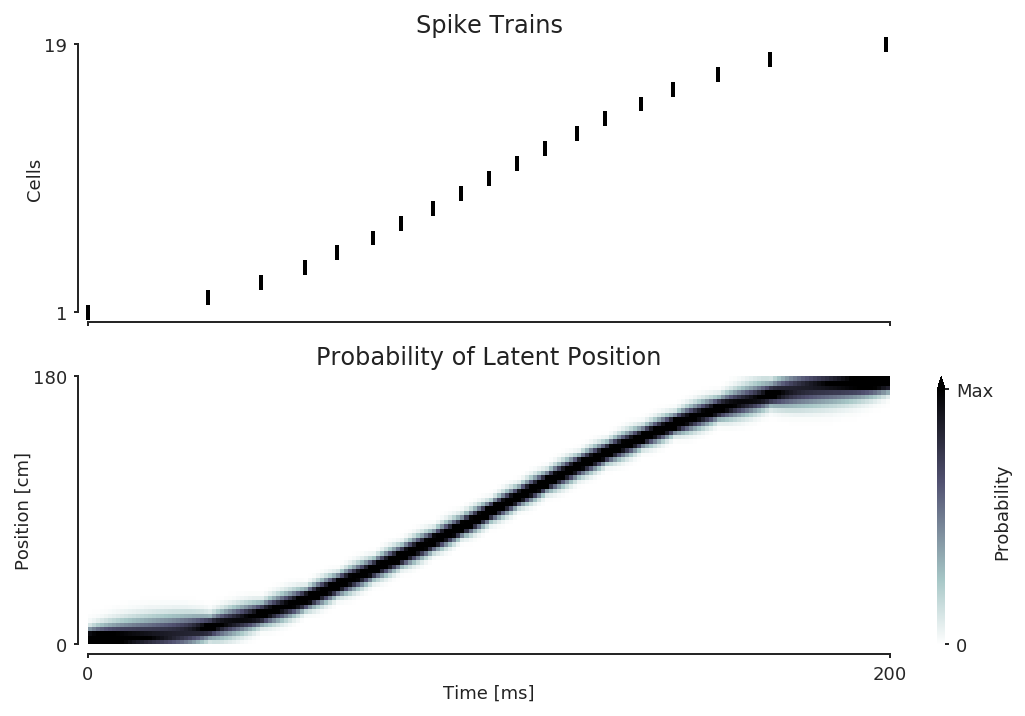

In [224]:
fig, axes = plt.subplots(
    2, 1, figsize=(TWO_COLUMN, PAGE_HEIGHT / 2), constrained_layout=True
)

plot_spikes(test_spikes2, replay_time2, ax=axes[0])
axes[0].set_xlabel("")
axes[0].set_xticklabels([])
plot_posterior(decoder, decoder_results, linear_distance, ax=axes[1])
sns.despine(offset=5)

save_figure(os.path.join("talk", "full_decoder_simulated_example"))